In [62]:
import numpy as np
import networkx as nx
# import netwulf as nw
import matplotlib.pyplot as plt
import json 
import random 
import sys
import pandas as pd
import ast
import nltk

# Part 1

1. Random Network

In [52]:
N = 12488
L = 38747
#substituting p out of the formula
p = 2*L/(N*(N-1))
print("p: ", np.round(p, 7))

#average degrees
k = p * (N-1)
print(f"Average degree: {np.round(k, 3)}")

#generate random graph
def generate_random_g (N,p): 
    G = np.random.uniform(size=(N, N)) < p
    #append pairs that are true in G
    edges = np.array(np.where(G)).T
    print(f"Number of edges: {len(edges)}")

    #make a graph 
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph 

graph = generate_random_g (N,p)




p:  0.000497
Average degree: 6.205
Number of edges: 77209


In [51]:
# Visualize the network
plt.figure(figsize=(10, 10))
nx.draw(graph, node_size=10, edge_color="blue", with_labels=False)
plt.title("Random Network Visualization")
plt.show()

We have an average degree <k> equals to 6.205 and p 

What regime does your random network fall into? Is it above or below the critical threshold?
According to the textbook, what does the network's structure resemble in this regime?
Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations.

2. Degree Distribution

In [5]:
with open('network_graph.json', 'r') as file:
    reaL_network = json.load(file)
real_network_graph = nx.readwrite.json_graph.node_link_graph(reaL_network)

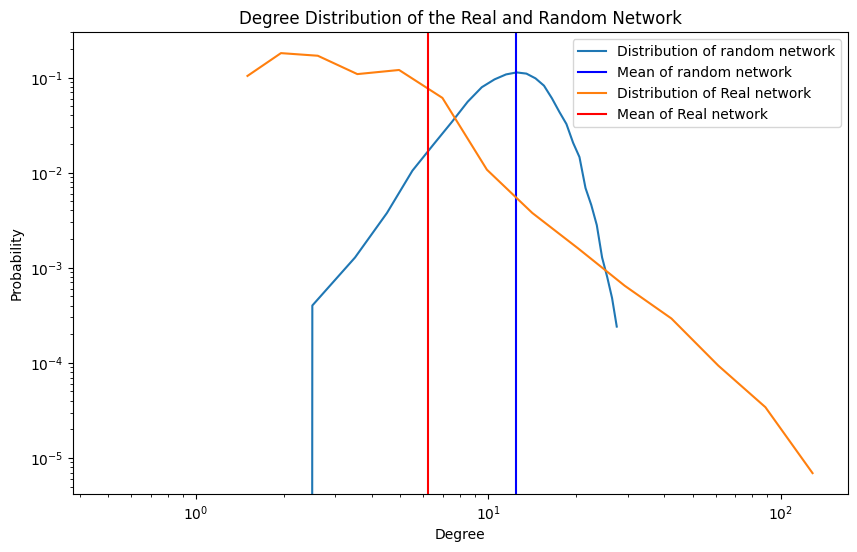

In [50]:

def compute_degree_distribution(network, log=False):
    # Extract the degree sequence
    degrees = [degree for node, degree in network.degree()]
    
    # Compute the histogram of the degree distribution
    max_degree = max(degrees)
    if log:
        bins = np.geomspace(1, max_degree + 2,15)
    else:
        bins = np.arange(0, max_degree + 2)
    hist, edges = np.histogram(degrees, bins=bins, density=True)
    
    return hist, edges, degrees


def plot_degree_distribution(hist, edges, degrees, title="Degree Distribution", name = "random", col="b"):
    # Plot the degree distribution
    #plt.bar(edges[:-1] + 0.5, hist, width=0.8, alpha=0.7)
    plt.loglog(edges[:-1] + 0.5, hist, label = "Distribution of "+name+" network")
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Probability")

    plt.axvline(x = np.mean(degrees), color=col, label = 'Mean of '+name+' network')
    plt.legend()
    #plt.savefig("img/"+title+".png")
    


plt.figure(figsize=(10, 6))
hist, edges, degrees = compute_degree_distribution(graph)  # Use your network variable here
plot_degree_distribution(hist, edges, degrees, title="Degree Distribution of the Real and Random Network")

hist, edges, degrees = compute_degree_distribution(real_network_graph, log = True)  # Use your network variable here
plot_degree_distribution(hist, edges, degrees, title="Degree Distribution of the Real and Random Network", name="Real", col="r")


plt.legend()
plt.savefig("img/test2.png")

<img src="img/test2.png" width="" align="" />

Answer the following questions (max 200 words in total):Does the average degree meaningfully represents the network's characteristics, especially in light of the insights gained from exploring heavy-tailed distributions? Discuss its adequacy or limitations in capturing the essence of the network's structural properties.What differences can you observe between the real and the random distributions? How does the shape of the degree distribution for each network inform us about the network's properties? (max 150 words)

# Part 2: Network Analysis in Computational Social Science

Part 1: Part 1: Assortativity Coefficient

# 

In [7]:
with open('network_graph.json', 'r') as file:
    network = json.load(file)

def guet_assortivity(nerwork):

    nodes = network['nodes']
    links = network['links']

    # Map node names (or IDs) to countries
    node_country = {node['id']: node['country'] for node in nodes}

    # Initialize variables to calculate assortativity
    e_ii = 0
    sum_aibi = 0
    country_edge_count = {}
    total_links = len(links)

    # Count the links by country
    for link in links:
        source_country = node_country.get(link['source'])
        target_country = node_country.get(link['target'])
        
        # Increment e_ii if both nodes are from the same country
        if source_country == target_country:
            e_ii += 1
        
        # Update country edge counts for source and target countries
        if source_country:
            
            country_edge_count[source_country] = country_edge_count.get(source_country, 0) + 1
        if target_country:
            country_edge_count[target_country] = country_edge_count.get(target_country, 0) + 1

    # Normalize e_ii by the total number of links
    e_ii /= total_links

    # Calculate sum_aibi
    for country, edge_count in country_edge_count.items():
        ai = edge_count / total_links
        sum_aibi += ai ** 2

    # Calculate assortativity coefficient
    r = (e_ii - sum_aibi) / (1 - sum_aibi)
    return r

r = guet_assortivity(network)


print(f'Assortativity coefficient: {r}')

Assortativity coefficient: -0.05890140099693153


Part 2 : Part 2: Configuration model 

In [8]:
network_graph = nx.readwrite.json_graph.node_link_graph(network)

In [9]:
def double_edge_swap(network, num_swaps=None):

    #Create an exact copy of your original network.
    copy_net = network.copy() 
    edges = list(copy_net.edges())
    E = len(edges)

    if num_swaps is None:
        num_swaps = E * 10

    successful_swaps = 0

    while successful_swaps < num_swaps:

        selected = False 
        attempts = 0 
        max_attemps = 100 

        while not selected and attempts < max_attemps: 
            attempts += 1
            e1 = random.choice(edges)
            e2 = random.choice(edges)

            if e1 != e2 and e1[0] != e2[1] and e1[1] != e2[0]:
                selected = True

        u, v = e1
        x, y = e2
        
        # Optionally flip the direction of an edge 50% of the time
        if random.random() < 0.5:
            u, v = v, u 
        
        e1_prime = (u, x)
        e2_prime = (v, y)


        if e1_prime in edges or e2_prime in edges:
                continue

        # Perform the swap
        edges.remove(e1)
        edges.remove(e2)
        edges.append(e1_prime)
        edges.append(e2_prime)

        successful_swaps += 1
        progress_percentage = successful_swaps / num_swaps * 100
        sys.stdout.write("\rProgress: {:.2f}%".format(progress_percentage))
        sys.stdout.flush()

    return edges 

    
new_network = double_edge_swap(network_graph)
new_network

Progress: 1.89%

KeyboardInterrupt: 

In [ ]:
def calculate_node_degrees(edges):

    degrees = {}
    for edge in edges:
        
        u, v = edge
        degrees[u] = degrees.get(u, 0) + 1
        degrees[v] = degrees.get(v, 0) + 1

    return degrees

def compare_degrees(original_edges, randomized_edges):

    original_degrees = calculate_node_degrees(original_edges)
    randomized_degrees = calculate_node_degrees(randomized_edges)
    
    # Check if the degrees match between the two networks
    return original_degrees == randomized_degrees

print(f"Do the networks match: {compare_degrees ( new_network, network_graph.edges)}")

NameError: name 'new_network' is not defined

Part 3 : Analyzing Assortativity in Random Networks

In [ ]:
for i in range (100): 
    random_graph = double_edge_swap(network_graph)
    coefficient_r = guet_assortivity(random_graph)
    
    plt_hist (coefficient_r, bins=10, edgecolor='black')
    plt.axvline(r, color='r', linestyle='dashed', linewidth=2)
    plt.title('Distribution of Assortativity Coefficients')
    plt.xlabel('Assortativity Coefficient')
    plt.ylabel('Frequency')
    plt.show()

Progress: 7.48%

KeyboardInterrupt: 

Analyze whether your network shows a tendency for high-degree scientists to connect with other high-degree scientists and vice versa.

Part 5: Reflection questions (max 250 words for the 3 questions)7. Assortativity by degree. Were the results of the degree assortativity in line with your expectations? Why or why not?8. Edge flipping. In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing e_1 from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?9. Distribution of assortativity in random networks. Describe the distribution of degree assortativity values you observed for the random networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations.

### Exercise 2: Central nodes

Find the 5 most central scientists according to the closeness centrality. What role do you imagine scientists with high closeness centrality play?Find the 5 most central scientists according to eigenvector centrality.Plot the closeness centrality of nodes vs their degree. Is there a correlation between the two? Did you expect that? Why?Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?

# Part 3 - Words that characterise Computational Social Science communities

Part 1: TF-IDF

TF stands for term frequency, it measures how often a term appears in a document measured by (Total times term appears in the document)/(Total amount of terms in the document)

IDF stands for inverse document frequency. It measures how frequently terms appear in documents, and weights terms that appear frequently in all the documents in the corpus lower.

The TF-IDF is the product of TF and IDF, and weighs how important a document is relative to the entire corpus, useful for when you are searching for specific documents in a library, or websites like when googling.

Part 1: TF-IDF and the Computational Social Science communities.

In [21]:
with open('network_graph.json', 'r') as file:
    network = json.load(file)

network = nx.readwrite.json_graph.node_link_graph(network)

papers_df = pd.read_csv('full_df_unique.csv')

papers_df.dropna(subset=['abstract_inverted_index'], inplace=True)

papers_df['author_ids'] = papers_df['author_ids'].apply(lambda x: ast.literal_eval(x))
papers_df['abstract_inverted_index'] = papers_df['abstract_inverted_index'].apply(ast.literal_eval)

In [26]:
network.nodes()

NodeView(('https://openalex.org/A5052099873', 'https://openalex.org/A5071165387', 'https://openalex.org/A5090030525', 'https://openalex.org/A5004774200', 'https://openalex.org/A5038390320', 'https://openalex.org/A5016057473', 'https://openalex.org/A5038488889', 'https://openalex.org/A5067567133', 'https://openalex.org/A5023753116', 'https://openalex.org/A5059787882', 'https://openalex.org/A5070491108', 'https://openalex.org/A5014048759', 'https://openalex.org/A5033081182', 'https://openalex.org/A5042890616', 'https://openalex.org/A5039841997', 'https://openalex.org/A5031799782', 'https://openalex.org/A5025218537', 'https://openalex.org/A5046546654', 'https://openalex.org/A5029749535', 'https://openalex.org/A5072774321', 'https://openalex.org/A5050495630', 'https://openalex.org/A5012791383', 'https://openalex.org/A5065286115', 'https://openalex.org/A5071072809', 'https://openalex.org/A5027323565', 'https://openalex.org/A5025690046', 'https://openalex.org/A5032488864', 'https://openalex.

In [33]:
#find communities in the network
communities = nx.algorithms.community.greedy_modularity_communities(network)

In [128]:
# Create a mapping of authors to communities
author_community_map = {author: i for i, community in enumerate(communities) for author in community}

# Assign communities to papers using the map function
papers_df['community'] = papers_df['author_ids'].apply(lambda authors: [author_community_map.get(author) for author in authors if author in author_community_map])

# Flatten the list of communities in each row
papers_df = papers_df.explode('community')

#drop duplicates
papers_df.drop_duplicates(subset=['id'], inplace=True)

#print the number of unique communities
papers_df.head()

id  publication_year  cited_by_count  \
0  https://openalex.org/W2157082398            2008.0          1880.0   
1  https://openalex.org/W2095072199            2005.0           717.0   
2  https://openalex.org/W2102017123            2015.0           395.0   
3  https://openalex.org/W2513567506            2017.0           360.0   
4  https://openalex.org/W2074562205            2014.0           181.0   

                                          author_ids  \
0  [https://openalex.org/A5014647140, https://ope...   
1                 [https://openalex.org/A5014647140]   
2  [https://openalex.org/A5014647140, https://ope...   
3  [https://openalex.org/A5072266097, https://ope...   
4  [https://openalex.org/A5078066191, https://ope...   

                                               title  \
0  Hierarchical structure and the prediction of m...   
1      Finding local community structure in networks   
2  Systematic inequality and hierarchy in faculty...   
3  The ground truth about metadata and community ...   
4   Power-law distributions in binned empirical data   

                             abstract_inverted_index community  
0  {'Networks': [0], 'have': [1], 'in': [2, 16, 3...         1  
1  {'Although': [0], 'the': [1, 18, 26, 46, 57, 7...         1  
2  {'The': [0], 'faculty': [1, 26, 48, 66, 76, 11...         1  
3  {'Across': [0], 'many': [1], 'scientific': [2]...         1  
4  {'Many': [0], 'man-made': [1], 'and': [2, 13, ...         1

In [89]:
#compute community size
community_sizes = papers_df['community'].value_counts()

#identify top 5 communities by size
top_communities = community_sizes.nlargest(5)

#calculate the term frequency of each community
def calculate_term_frequency(community):
    # Extract the abstracts of papers in the community
    abstracts = papers_df[papers_df['community'] == community]['abstract_inverted_index']
    
    # Flatten the list of abstracts
    all_abstracts = [term for abstract in abstracts for term in abstract]
    
    # Compute the term frequency
    term_frequency = pd.Series(all_abstracts).value_counts()
    
    #remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    
    #lowercase the terms
    term_frequency.index = term_frequency.index.str.lower()
    term_frequency = term_frequency[~term_frequency.index.isin(stop_words)]
    
    return term_frequency

# #print the top 5 terms in the top 5 communities
# for community in top_communities.index:
#     term_frequency = calculate_term_frequency(community)
#     print(f"Community {community}:")
#     print(term_frequency.nlargest(5))
#     print()


#compute the IDF of each term
def calculate_inverse_document_frequency(community):
    # Extract the abstracts of papers in the community
    abstracts = papers_df[papers_df['community'] == community]['abstract_inverted_index']
    
    # Flatten the list of abstracts
    all_abstracts = [set(abstract) for abstract in abstracts]
    
    # Compute the document frequency
    document_frequency = pd.Series([term for abstract in all_abstracts for term in abstract]).value_counts()
    
    # Compute the inverse document frequency
    inverse_document_frequency = 1 / np.log(1 + document_frequency)
    
    #remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    
    #lowercase the terms
    inverse_document_frequency.index = inverse_document_frequency.index.str.lower()
    inverse_document_frequency = inverse_document_frequency[~inverse_document_frequency.index.isin(stop_words)]
    
    return inverse_document_frequency

#calculate the IDF of the top 5 communities
top_5_idf = {}
for community in top_communities.index:
    inverse_document_frequency = calculate_inverse_document_frequency(community)
    top_5_idf[community] = inverse_document_frequency


#find the top 10 terms in the top 9 communities
top_9_c = community_sizes.nlargest(9)
top_9_tfidf = {}
for community in top_9_c.index:
    term_frequency = calculate_term_frequency(community)
    inverse_document_frequency = calculate_inverse_document_frequency(community)
    print(f"Community {community}:")
    # print(term_frequency.nlargest(10))
    
    #print the top TF-IDF terms
    tf_idf = term_frequency * inverse_document_frequency
    print(tf_idf.nlargest(10))
    
    print()

Community 0:
also         581.406101
research     291.424398
important    264.013192
work         248.143547
framework    232.273902
dynamics     218.457414
time         212.797519
novel        210.633476
simple       209.190781
impact       207.748086
Name: count, dtype: float64

Community 1:
work         154.368369
users        125.514469
often        112.530213
time         100.988653
data          94.736974
approach      92.332483
including     90.889788
potential     89.447093
general       85.119007
different     84.397660
Name: count, dtype: float64



Community 2:
may           113.972908
also           93.775178
present        69.249362
use            64.921277
different      62.806507
data           62.035887
first          60.593192
empirical      59.150497
individual     59.150497
often          57.707802
Name: count, dtype: float64

Community 6:
information    108.202128
may             83.676312
findings        66.363972
individual      63.478582
experiments     54.822412
role            54.822412
important       51.937021
network         51.937021
different       50.973397
effects         48.242679
Name: count, dtype: float64

Community 3:
may             105.316738
evidence         79.348227
research         70.692057
participants     64.921277
whether          64.921277
political        63.478582
important        56.265107
media            53.379717
often            53.379717
information      49.051631
Name: count, dtype: float64

Community 11:
different      90.889788
within         76.462837
complex        69.249362
metho

Different bases of logarithms result in different scoring which will result in different search results, but the words will still be in the same order

Describe similarities and differences between the communities.Why aren't the TFs not necessarily a good description of the communities?Next, we calculate IDF for every word.What base logarithm did you use? Is that important?

Part 2: The Wordcloud

Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?Look up online the top author in each community. In light of your search, do your results make sense?

In [167]:
#load authors info
authors_df = pd.read_csv('authors_info.csv')

#add https://openalex.org/ to the author ids
authors_df['author_id'] = authors_df['author_id'].apply(lambda x: 'https://openalex.org/' + str(x))
#add the community to the authors
authors_df['community'] = authors_df['author_id'].apply(lambda x: author_community_map.get(x))

for author in authors_df['author_id']:
    for id, community in enumerate(communities):
        # print(author)
        # print(list(community))
        # break
        if author in list(community):
            authors_df.loc[authors_df['author_id'] == author, 'community'] = id
            break
#remove authors with more than 1000 works_count
authors_df = authors_df[authors_df['works_count'] < 1000]

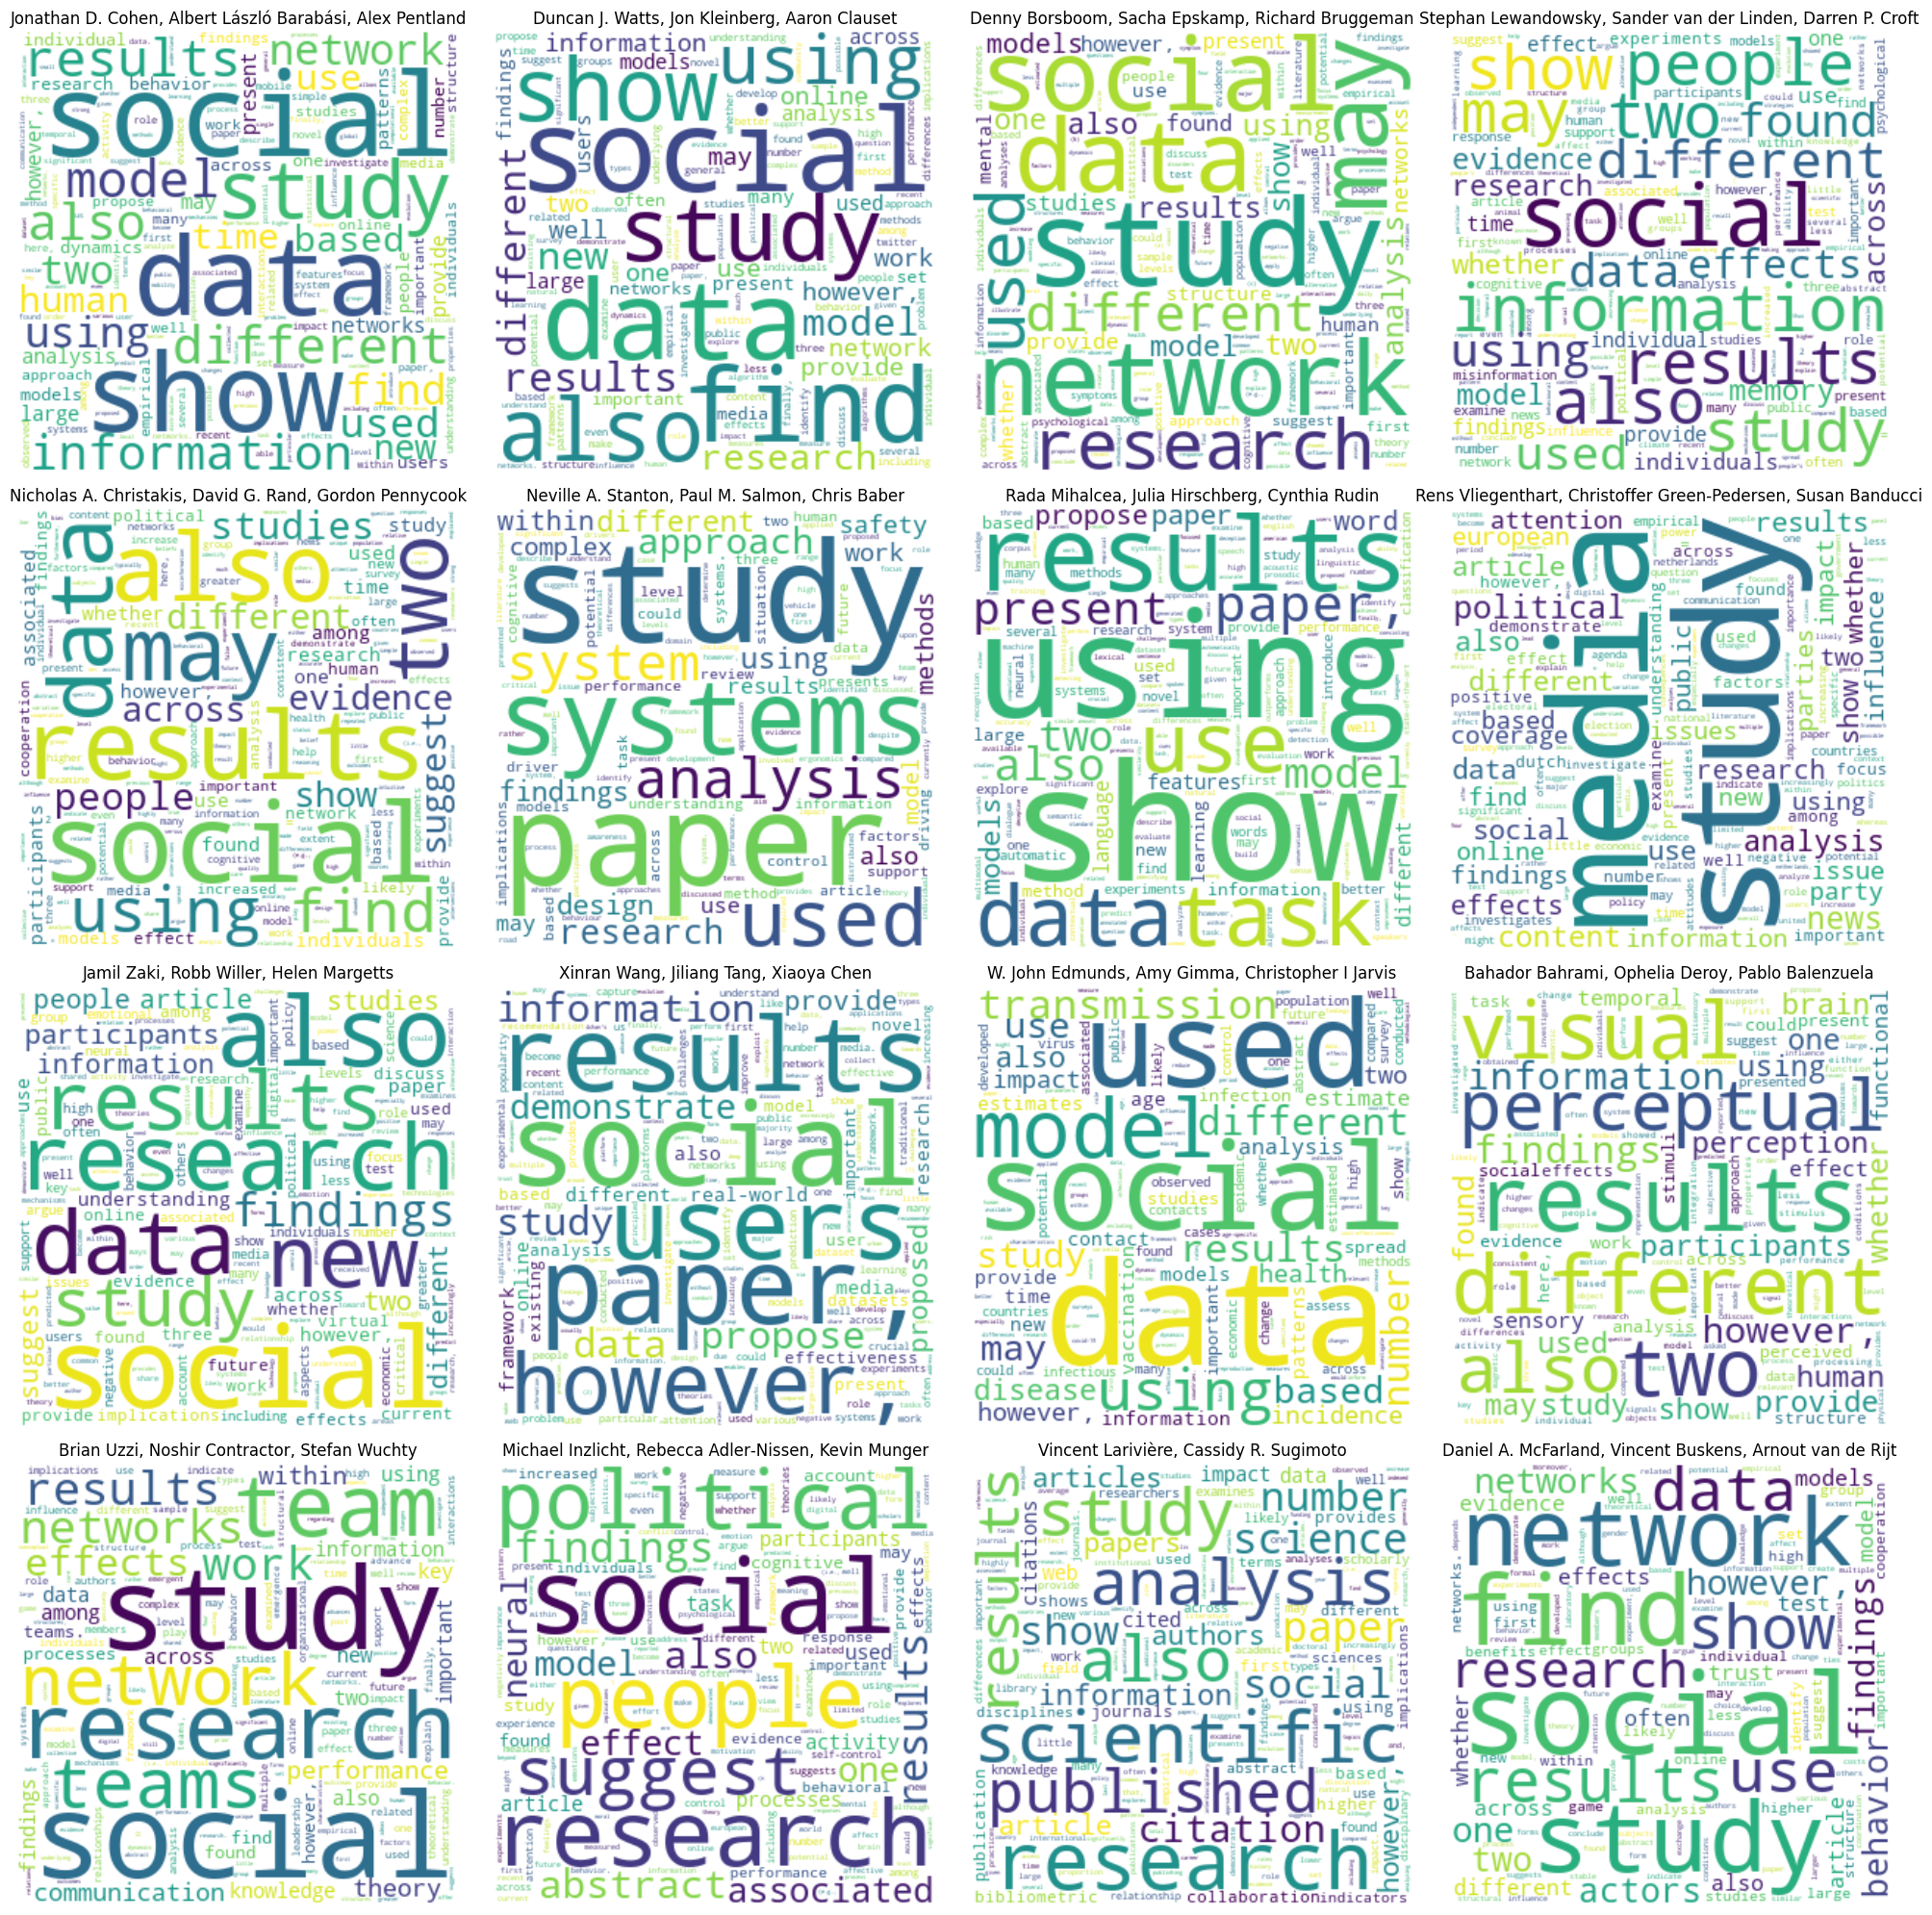

In [168]:
import wordcloud

#get the TF-IDF for the top 16 communities
top_16_c = community_sizes.nlargest(16)
top_16_tfidf = {}
for community in top_16_c.index:
    term_frequency = calculate_term_frequency(community)
    inverse_document_frequency = calculate_inverse_document_frequency(community)
    
    # Compute the TF-IDF
    tf_idf = term_frequency * inverse_document_frequency
    top_16_tfidf[community] = tf_idf
    

#remove misc words
misc_words = ['may', 'also','often', 'within', 'use']

for community, tf_idf in top_16_tfidf.items():
    top_16_tfidf[community] = tf_idf[~tf_idf.index.isin(misc_words)]
    
    #remove duplicates
    top_16_tfidf[community] = tf_idf[~tf_idf.index.duplicated()]


# Create a word cloud for each community
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, (community, tf_idf) in enumerate(top_16_tfidf.items()):
    ax = axes[i // 4, i % 4]
    wc = wordcloud.WordCloud(width=300, height=300, background_color='white').generate_from_frequencies(tf_idf)
    ax.imshow(wc, interpolation='bilinear')
    #set the title of the word cloud as the 3 top authors by cited_by_count in the community
    top_3_authors = authors_df[authors_df['community'] == community].nlargest(3, 'cited_by_count')
    
    #get the display names
    top_3_authors = top_3_authors['display_name'].tolist()
    
    ax.set_title(', '.join(top_3_authors))
    
    
    ax.axis('off')
plt.tight_layout()
plt.show()


In [99]:
#print the top TF-IDF terms in community n
def top_idf(community, n=10):
    term_frequency = calculate_term_frequency(community)
    inverse_document_frequency = calculate_inverse_document_frequency(community)
    
    # Compute the TF-IDF
    tf_idf = term_frequency * inverse_document_frequency
    return tf_idf.nlargest(n)

print(top_idf(4, 10))

results     75.020142
results     75.020142
study       60.593192
also        53.379717
media       47.608936
research    46.166241
users       43.691483
analysis    38.952766
model       38.952766
new         37.510071
Name: count, dtype: float64


author_ids
[https://openalex.org/A5007176508]                                                                                                                                                                              11
[https://openalex.org/A5016268748, https://openalex.org/A5068695616]                                                                                                                                             8
[https://openalex.org/A5078699564]                                                                                                                                                                               7
[https://openalex.org/A5072363876]                                                                                                                                                                               6
[https://openalex.org/A5047379680, https://openalex.org/A5016268748, https://openalex.org/A5068695616]                                           

In [105]:
papers_df

id  publication_year  cited_by_count  \
0     https://openalex.org/W2157082398            2008.0          1880.0   
1     https://openalex.org/W2095072199            2005.0           717.0   
2     https://openalex.org/W2102017123            2015.0           395.0   
3     https://openalex.org/W2513567506            2017.0           360.0   
4     https://openalex.org/W2074562205            2014.0           181.0   
...                                ...               ...             ...   
7278  https://openalex.org/W2942138835            2019.0            13.0   
7279  https://openalex.org/W3035970587            2020.0            11.0   
7280  https://openalex.org/W3209972423            2021.0            50.0   
7281  https://openalex.org/W2786665112            2017.0            12.0   
7282  https://openalex.org/W1978240667            2010.0            29.0   

                                             author_ids  \
0     [https://openalex.org/A5014647140, https://ope...   
1                    [https://openalex.org/A5014647140]   
2     [https://openalex.org/A5014647140, https://ope...   
3     [https://openalex.org/A5072266097, https://ope...   
4     [https://openalex.org/A5078066191, https://ope...   
...                                                 ...   
7278  [https://openalex.org/A5027124881, https://ope...   
7279  [https://openalex.org/A5065220600, https://ope...   
7280  [https://openalex.org/A5042355795, https://ope...   
7281  [https://openalex.org/A5066939601, https://ope...   
7282  [https://openalex.org/A5003147310, https://ope...   

                                                  title  \
0     Hierarchical structure and the prediction of m...   
1         Finding local community structure in networks   
2     Systematic inequality and hierarchy in faculty...   
3     The ground truth about metadata and community ...   
4      Power-law distributions in binned empirical data   
...                                                 ...   
7278                    Conservation of Procrastination   
7279  A novel framework for selecting sustainable he...   
7280  Deepfake detection by human crowds, machines, ...   
7281  Mapping the Post-communist Class Structure: Fi...   
7282  Neural networks for relational learning: an ex...   

                                abstract_inverted_index community  
0     {'Networks': [0], 'have': [1], 'in': [2, 16, 3...         1  
1     {'Although': [0], 'the': [1, 18, 26, 46, 57, 7...         1  
2     {'The': [0], 'faculty': [1, 26, 48, 66, 76, 11...         1  
3     {'Across': [0], 'many': [1], 'scientific': [2]...         1  
4     {'Many': [0], 'man-made': [1], 'and': [2, 13, ...         1  
...                                                 ...       ...  
7278  {'Productivity': [0], 'behavior': [1, 34, 116]...         4  
7279  {'Health-care': [0], 'waste': [1], '(HCW)': [2...         4  
7280  {'The': [0], 'recent': [1], 'emergence': [2], ...         3  
7281  {'In': [0], 'this': [1], 'article,': [2], 'we'...       233  
7282  {'In': [0, 45, 144], 'the': [1, 21, 26, 29, 32...        88  

[6915 rows x 7 columns]